In [1]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [83]:
import wfdb
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Masking
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
from scipy.stats import zscore

In [2]:
#전체레코드 번호 리스트 
record_list = [ 
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
    '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
    '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
    '222', '223', '228', '230', '231', '232', '233', '234'
]

In [3]:
beat_labels = ['N', 'L', 'R', 'A', 'V', 'E', 'F', '/', 'a', 'j']  # beat 라벨
def map_label(lbl): #라벨 분류 
    if lbl == 'N':
        return '정상'
    elif lbl in beat_labels:
        return '비정상'
    else:
        return None  

In [4]:
#ECG 신호 심박으로 변환 

all_results = [] #전체 결과 저장 

for record_name in record_list:
    try:
        record = wfdb.rdrecord(record_name, pn_dir='mitdb')
        ann = wfdb.rdann(record_name, 'atr', pn_dir='mitdb')
        fs = record.fs
        
        r_peaks = np.array(ann.sample)
        labels = np.array(ann.symbol)

        valid_indices = [i for i, lbl in enumerate(labels) if map_label(lbl) is not None]
        
        r_peaks = r_peaks[valid_indices]
        labels = labels[valid_indices]
        rr_intervals_sec = np.diff(r_peaks) / fs
        heart_rates = 60 / rr_intervals_sec
        labels_rr = labels[1:]

        mapped_labels = [map_label(l) for l in labels_rr]

        # 구간별 묶기
        result = []
        current_chunk = []
        current_label = mapped_labels[0]

        for hr, lbl in zip(heart_rates, mapped_labels):
            if lbl != current_label:
                if len(current_chunk) > 3:
                    result.append({'user_id': record_name, 'label': current_label, 'heart_rates': current_chunk})
                current_chunk = [hr]
                current_label = lbl
            else:
                current_chunk.append(hr)
        if len(current_chunk) > 3:
            result.append({'user_id': record_name, 'label': current_label, 'heart_rates': current_chunk})

        all_results.extend(result)

        print(f"{record_name} 처리 완료")

    except Exception as e:
        print(f"{record_name} 처리 실패: {e}")

100 처리 완료
101 처리 완료
102 처리 완료
103 처리 완료
104 처리 완료
105 처리 완료
106 처리 완료
107 처리 완료
108 처리 완료
109 처리 완료
111 처리 완료
112 처리 완료
113 처리 완료
114 처리 완료
115 처리 완료
116 처리 완료
117 처리 완료
118 처리 완료
119 처리 완료
121 처리 완료
122 처리 완료
123 처리 완료
124 처리 완료
200 처리 완료
201 처리 완료
202 처리 완료
203 처리 완료
205 처리 완료
207 처리 완료
208 처리 완료
209 처리 완료
210 처리 완료
212 처리 완료
213 처리 완료
214 처리 완료
215 처리 완료
217 처리 완료
219 처리 완료
220 처리 완료
221 처리 완료
222 처리 완료
223 처리 완료
228 처리 완료
230 처리 완료
231 처리 완료
232 처리 완료
233 처리 완료
234 처리 완료


In [21]:
all=pd.DataFrame(all_results)

In [23]:
hr_df = pd.DataFrame(all['heart_rates'].to_list())
hr_df.columns = [f't_{i}' for i in range(hr_df.shape[1])]

df_all = pd.concat([all[['user_id', 'label']], hr_df], axis=1)

In [25]:
df_all

,user_id,label,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,...,t_2521,t_2522,t_2523,t_2524,t_2525,t_2526,t_2527,t_2528,t_2529,t_2530
0,100,정상,73.720137,73.972603,76.056338,75.789474,76.056338,73.469388,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,정상,60.335196,71.052632,73.972603,76.056338,77.697842,71.523179,70.129870,72.972973,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100,정상,63.905325,71.052632,73.469388,77.419355,73.220339,73.972603,73.972603,70.819672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100,정상,62.427746,72.000000,71.523179,72.240803,76.595745,80.000000,74.740484,73.972603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100,정상,61.538462,75.000000,77.697842,75.789474,74.482759,74.482759,73.972603,75.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2282,233,정상,81.818182,96.860987,101.886792,100.934579,101.408451,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2283,234,정상,93.506494,90.000000,91.914894,89.626556,88.163265,91.914894,93.103448,87.096774,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2284,234,정상,70.819672,92.307692,88.524590,93.103448,93.103448,93.913043,90.756303,93.103448,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2285,234,정상,67.080745,87.804878,88.524590,90.756303,92.307692,88.888889,90.000000,90.376569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


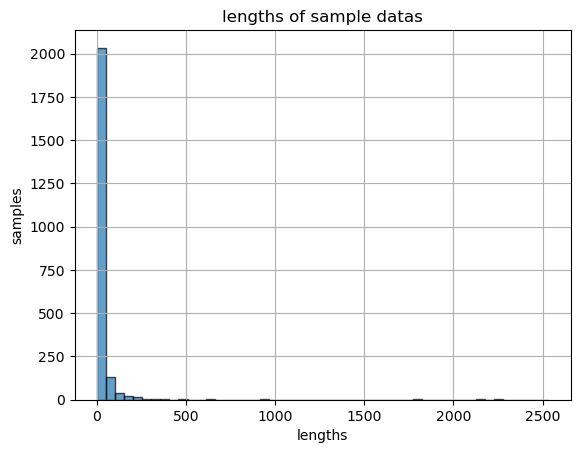

In [31]:
#시계열 길이 정하기 
ts_cols = [col for col in df_all.columns if col.startswith('t_')]
valid_lengths = df_all[ts_cols].notna().sum(axis=1)

plt.hist(valid_lengths, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel("lengths")
plt.ylabel("samples")
plt.title("lengths of sample datas")
plt.grid(True)
plt.show()

In [33]:
# 길이 100으로 자르기 

cutoff = 100
short_ts_cols = [f"t_{i}" for i in range(cutoff)]

df_all_short = df_all[['user_id', 'label'] + short_ts_cols]

In [53]:
df_norm=df_all_short[df_all_short['label'] == '정상'].reset_index(drop=True)
df_norm

,user_id,label,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,100,정상,73.720137,73.972603,76.056338,75.789474,76.056338,73.469388,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,정상,60.335196,71.052632,73.972603,76.056338,77.697842,71.523179,70.129870,72.972973,...,72.972973,75.261324,77.142857,75.524476,73.720137,69.902913,70.819672,73.972603,75.524476,76.325088
2,100,정상,63.905325,71.052632,73.469388,77.419355,73.220339,73.972603,73.972603,70.819672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100,정상,62.427746,72.000000,71.523179,72.240803,76.595745,80.000000,74.740484,73.972603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100,정상,61.538462,75.000000,77.697842,75.789474,74.482759,74.482759,73.972603,75.000000,...,77.697842,77.978339,79.120879,80.000000,77.419355,75.000000,74.482759,74.740484,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2065,233,정상,81.818182,96.860987,101.886792,100.934579,101.408451,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2066,234,정상,93.506494,90.000000,91.914894,89.626556,88.163265,91.914894,93.103448,87.096774,...,93.103448,91.914894,93.506494,95.575221,93.913043,93.103448,91.914894,90.756303,94.323144,93.506494
2067,234,정상,70.819672,92.307692,88.524590,93.103448,93.103448,93.913043,90.756303,93.103448,...,87.449393,91.525424,93.913043,88.524590,89.256198,91.139241,94.736842,91.914894,93.506494,91.139241
2068,234,정상,67.080745,87.804878,88.524590,90.756303,92.307692,88.888889,90.000000,90.376569,...,91.139241,88.163265,90.376569,90.000000,91.525424,87.449393,91.139241,91.525424,91.914894,88.524590


In [55]:
# 이상치 제거 
ts_cols = [col for col in df_norm.columns if col.startswith("t_")]
row_means = df_norm[ts_cols].mean(axis=1)
z_scores = zscore(row_means)
df_normal = df_norm[np.abs(z_scores) < 3].reset_index(drop=True)

In [57]:
df_normal

,user_id,label,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,100,정상,73.720137,73.972603,76.056338,75.789474,76.056338,73.469388,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,정상,60.335196,71.052632,73.972603,76.056338,77.697842,71.523179,70.129870,72.972973,...,72.972973,75.261324,77.142857,75.524476,73.720137,69.902913,70.819672,73.972603,75.524476,76.325088
2,100,정상,63.905325,71.052632,73.469388,77.419355,73.220339,73.972603,73.972603,70.819672,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100,정상,62.427746,72.000000,71.523179,72.240803,76.595745,80.000000,74.740484,73.972603,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100,정상,61.538462,75.000000,77.697842,75.789474,74.482759,74.482759,73.972603,75.000000,...,77.697842,77.978339,79.120879,80.000000,77.419355,75.000000,74.482759,74.740484,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2060,233,정상,81.818182,96.860987,101.886792,100.934579,101.408451,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2061,234,정상,93.506494,90.000000,91.914894,89.626556,88.163265,91.914894,93.103448,87.096774,...,93.103448,91.914894,93.506494,95.575221,93.913043,93.103448,91.914894,90.756303,94.323144,93.506494
2062,234,정상,70.819672,92.307692,88.524590,93.103448,93.103448,93.913043,90.756303,93.103448,...,87.449393,91.525424,93.913043,88.524590,89.256198,91.139241,94.736842,91.914894,93.506494,91.139241
2063,234,정상,67.080745,87.804878,88.524590,90.756303,92.307692,88.888889,90.000000,90.376569,...,91.139241,88.163265,90.376569,90.000000,91.525424,87.449393,91.139241,91.525424,91.914894,88.524590


In [39]:
df_abnormal=df_all_short[df_all_short['label'] != '정상'].reset_index(drop=True)
df_abnormal

,user_id,label,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,...,t_90,t_91,t_92,t_93,t_94,t_95,t_96,t_97,t_98,t_99
0,102,비정상,78.832117,75.261324,73.972603,68.354430,69.902913,72.727273,74.482759,75.000000,...,62.427746,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,102,비정상,123.428571,68.138801,73.972603,76.325088,75.000000,72.483221,69.230769,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,102,비정상,37.049743,75.789474,72.240803,69.230769,69.230769,72.483221,75.261324,72.727273,...,70.358306,68.789809,72.972973,75.524476,72.240803,73.972603,74.226804,70.358306,70.588235,69.902913
3,102,비정상,23.529412,75.261324,76.595745,72.000000,71.523179,71.523179,70.588235,72.000000,...,72.483221,76.325088,75.524476,70.129870,70.588235,71.760797,70.819672,72.972973,74.226804,76.056338
4,104,비정상,88.888889,72.240803,75.524476,75.261324,24.713959,72.240803,74.482759,74.226804,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,231,비정상,66.666667,69.902913,67.289720,62.247839,65.653495,65.653495,61.714286,65.853659,...,59.340659,60.504202,62.608696,57.446809,61.016949,57.142857,55.102041,60.674157,59.504132,57.600000
213,231,비정상,66.666667,72.000000,63.529412,62.068966,67.924528,59.668508,57.754011,63.343109,...,64.864865,60.167131,62.068966,65.256798,60.504202,60.167131,64.864865,59.833795,63.529412,64.670659
214,231,비정상,65.454545,69.902913,61.363636,62.790698,67.289720,61.016949,59.668508,63.716814,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215,231,비정상,66.055046,69.453376,63.905325,62.247839,65.060241,60.845070,65.256798,60.167131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df_normal.to_csv("df_normal.csv", index=False)
df_abnormal.to_csv("df_abnormal.csv", index=False)

In [61]:
X_normal = df_normal[short_ts_cols].to_numpy()
X_abnormal = df_abnormal[short_ts_cols].to_numpy()

# NaN → 0
X_normal = np.nan_to_num(X_normal, nan=0.0)
X_abnormal = np.nan_to_num(X_abnormal, nan=0.0)

# 정규화 
scaler = MinMaxScaler()
X_normal = scaler.fit_transform(X_normal.reshape(-1, 1)).reshape(X_normal.shape)
X_abnormal = scaler.transform(X_abnormal.reshape(-1, 1)).reshape(X_abnormal.shape)

# LSTM 입력 형태 (samples, timesteps, features)
X_normal = X_normal[..., np.newaxis]
X_abnormal = X_abnormal[..., np.newaxis]

# 정상 데이터 train/val split
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

# 테스트 데이터 = 정상 val + 비정상
X_test = np.concatenate([X_val, X_abnormal])
y_test = np.concatenate([
    np.zeros(len(X_val)),     # 정상 = 0
    np.ones(len(X_abnormal))  # 비정상 = 1
])

In [63]:
np.save("X_train.npy", X_train)
np.save("X_val.npy", X_val)
np.save("X_abnormal.npy", X_abnormal)

In [65]:
timesteps = X_train.shape[1]
features = X_train.shape[2]

inputs = Input(shape=(timesteps, features))
masked = Masking(mask_value=0.0)(inputs)
encoded = LSTM(32, return_sequences=True)(masked)
encoded = LSTM(16, return_sequences=False)(encoded)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(16, return_sequences=True)(decoded)
decoded = LSTM(32, return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(1))(decoded)

lstm_ae = Model(inputs, outputs)
lstm_ae.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [67]:
# 훈련
history = lstm_ae.fit(
    X_train, X_train,
    validation_data=(X_val, X_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - loss: 0.0267 - val_loss: 0.0127
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0111 - val_loss: 0.0087
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0074 - val_loss: 0.0110
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.0078 - val_loss: 0.0059
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 7/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 8/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0037 - val_loss: 0.0072
Epoch 9/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 10/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 11/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 12/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms

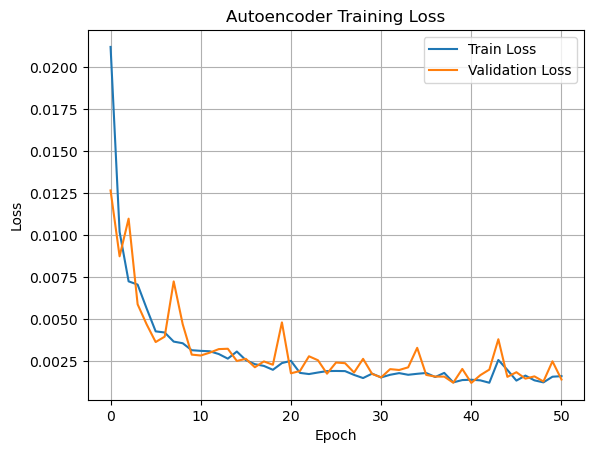

In [69]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Autoencoder Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
#테스트 
X_pred = lstm_ae.predict(X_test)
recon_errors = np.mean(np.mean((X_test - X_pred)**2, axis=1), axis=1)

roc_auc = roc_auc_score(y_test, recon_errors)
print(f"ROC AUC: {roc_auc:.4f}")

# PR AUC
precision, recall, _ = precision_recall_curve(y_test, recon_errors)
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
ROC AUC: 0.7883
PR AUC: 0.6151


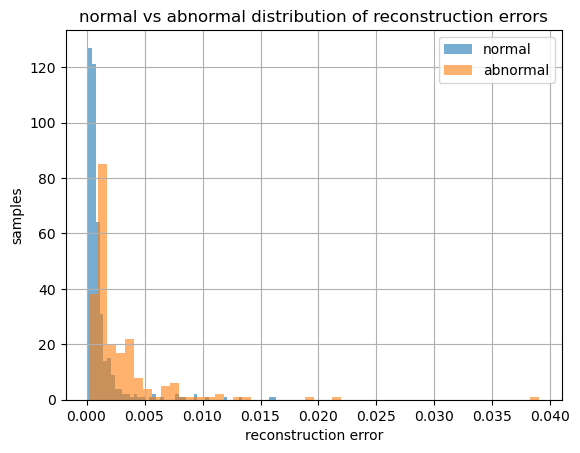

In [79]:
plt.hist(recon_errors[y_test == 0], bins=50, alpha=0.6, label='normal')
plt.hist(recon_errors[y_test == 1], bins=50, alpha=0.6, label='abnormal')
plt.xlabel('reconstruction error')
plt.ylabel('samples')
plt.title('normal vs abnormal distribution of reconstruction errors')
plt.legend()
plt.grid(True)
plt.show()

In [81]:
threshold = 0.005
y_pred = (recon_errors > threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["normal", "abnormal"]))

              precision    recall  f1-score   support

      normal       0.68      0.96      0.79       413
    abnormal       0.63      0.12      0.20       217

    accuracy                           0.67       630
   macro avg       0.65      0.54      0.50       630
weighted avg       0.66      0.67      0.59       630



In [85]:
# ROC curve 기반 threshold 찾기
fpr, tpr, thresholds = roc_curve(y_test, recon_errors)

# Youden's J = TPR - FPR 최대 지점
j_scores = tpr - fpr
best_index = j_scores.argmax()
best_threshold = thresholds[best_index]

print(f"Best threshold (Youden's J): {best_threshold:.5f}")

Best threshold (Youden's J): 0.00100


In [87]:
from sklearn.metrics import classification_report, confusion_matrix

# threshold 기준 이상 탐지
y_pred = (recon_errors > best_threshold).astype(int)

# 성능 보고서
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["normal", "abnormal"]))

# 혼동 행렬
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

      normal       0.88      0.71      0.78       413
    abnormal       0.60      0.82      0.69       217

    accuracy                           0.75       630
   macro avg       0.74      0.76      0.74       630
weighted avg       0.78      0.75      0.75       630

Confusion Matrix:
[[292 121]
 [ 39 178]]


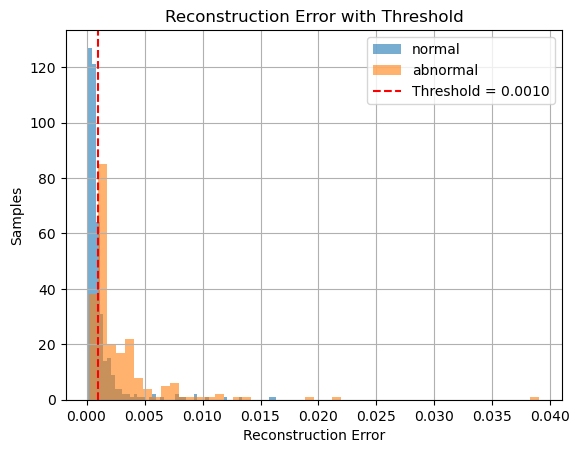

In [89]:
plt.hist(recon_errors[y_test == 0], bins=50, alpha=0.6, label='normal')
plt.hist(recon_errors[y_test == 1], bins=50, alpha=0.6, label='abnormal')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Threshold = {best_threshold:.4f}')
plt.xlabel('Reconstruction Error')
plt.ylabel('Samples')
plt.title('Reconstruction Error with Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [97]:
lstm_ae.save("lstm_autoencoder_model.keras")

In [95]:
np.save("best_threshold.npy", best_threshold)